In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, multiply
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework import ops
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

import keras.backend as K
from keras import optimizers
import random
import sys
import cv2
import os
from skimage import io
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras import initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import csv
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

category_num=3
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
config = tf.compat.v1.ConfigProto(log_device_placement=True,
inter_op_parallelism_threads=0,
intra_op_parallelism_threads=0,
allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1



Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


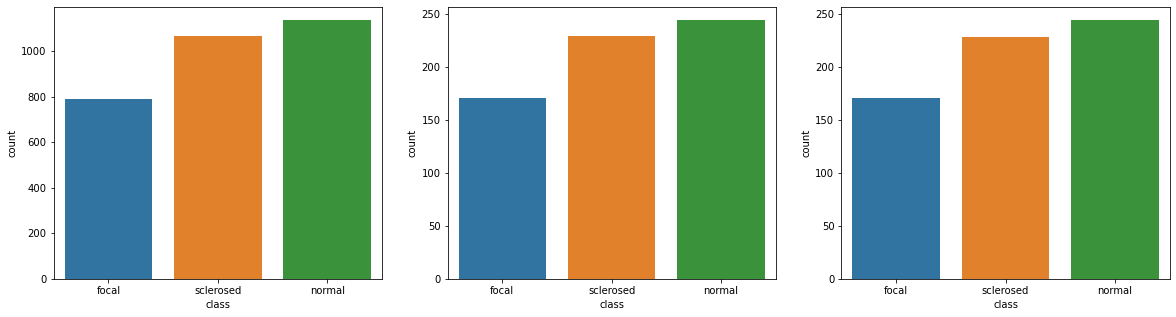

In [2]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [3]:
category_num=3
IMG_SIZE = 150

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [5]:
def train(BATCH_SIZE):
    train_generator = train_datagen.flow_from_directory(train_folders,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        target_size=(IMG_SIZE, IMG_SIZE))
    return train_generator

In [6]:
def validation(BATCH_SIZE):
    
    validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                                  batch_size=BATCH_SIZE, 
                                                                  class_mode='categorical', 
                                                                  target_size=(IMG_SIZE, IMG_SIZE))
    return validation_generator

In [7]:
def test(BATCH_SIZE):
    test_generator = test_datagen.flow_from_directory(test_folders,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMG_SIZE, IMG_SIZE))
    return test_generator

In [8]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


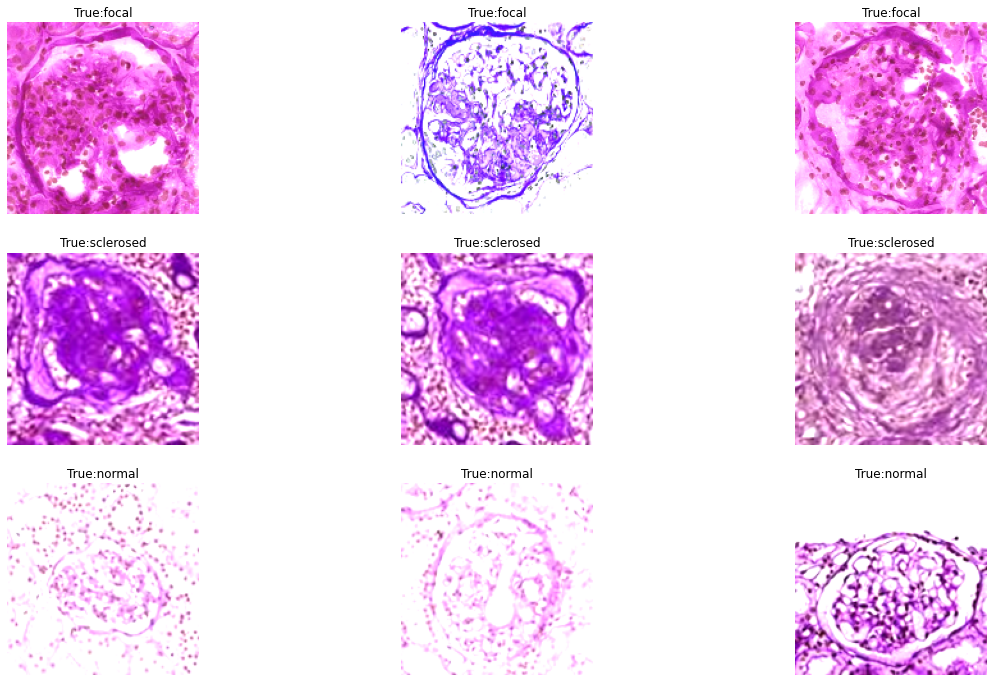

In [9]:
show_few_images(3,None)

In [10]:
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

In [11]:
with strategy.scope():
    model = tf.keras.applications.VGG16(pooling='avg', weights=None, include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in model.layers:
                layers.trainable=False
    last_output = model.layers[-1].output
    output = Flatten()(last_output)
    output = Dense(128, activation = 'relu')(output)
    output = Dense(3, activation = 'softmax')(output)
    model = Model(model.input, output)
    model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(1)
data_validation = validation(1)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(1)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
2993/2993 [==============================] - 90s 26ms/step - loss: 1.0670 - acc: 0.4003 - val_loss: 0.9620 - val_acc: 0.5202
Epoch 2/30
2993/2993 [==============================] - 72s 24ms/step - loss: 0.9869 - acc: 0.4896 - val_loss: 0.8606 - val_acc: 0.6090
Epoch 3/30
2993/2993 [==============================] - 76s 25ms/step - loss: 0.8967 - acc: 0.5537 - val_loss: 0.7686 - val_acc: 0.6137
Epoch 4/30
2993/2993 [==============================] - 77s 26ms/step - loss: 0.7952 - acc: 0.6082 - val_loss: 0.6930 - val_acc: 0.7134
Epoch 5/30
2993/2993 [==============================] - 77s 26ms/step - loss: 0.7458 - acc: 0.6598 - val_loss: 0.6753 - val_acc: 0.7165
Epoch 6/30
2993/2993 [==============================] - 77s 26ms/step - loss: 0.6658 - acc: 0.7103 - val_loss: 0.5784 - val_acc: 0.7586
Epoch 7/30
2993/2993 [==============================] - 78s 26ms/step - loss: 0.6213 - acc: 0.7345 - 

[0.49538689851760864, 0.8040435314178467]

In [13]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(2)
data_validation = validation(2)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(2)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
1497/1497 [==============================] - 70s 38ms/step - loss: 0.3977 - acc: 0.8406 - val_loss: 0.3794 - val_acc: 0.8551
Epoch 2/30
1497/1497 [==============================] - 58s 39ms/step - loss: 0.3968 - acc: 0.8403 - val_loss: 0.3771 - val_acc: 0.8598
Epoch 3/30
1497/1497 [==============================] - 58s 38ms/step - loss: 0.4068 - acc: 0.8353 - val_loss: 0.4357 - val_acc: 0.8536
Epoch 4/30
1497/1497 [==============================] - 58s 39ms/step - loss: 0.3909 - acc: 0.8420 - val_loss: 0.4040 - val_acc: 0.8458
Epoch 5/30
1497/1497 [==============================] - 58s 39ms/step - loss: 0.3960 - acc: 0.8410 - val_loss: 0.4277 - val_acc: 0.8380
Epoch 6/30
1497/1497 [==============================] - 59s 39ms/step - loss: 0.3952 - acc: 0.8456 - val_loss: 0.4054 - val_acc: 0.8380
Epoch 7/30
1497/1497 [==============================] - 59s 39ms/step - loss: 0.4028 - acc: 0.8333 - 

[0.3447330892086029, 0.8491446375846863]

In [14]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(4)
data_validation = validation(4)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(4)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
749/749 [==============================] - 60s 62ms/step - loss: 0.3485 - acc: 0.8617 - val_loss: 0.4050 - val_acc: 0.8614
Epoch 2/30
749/749 [==============================] - 53s 70ms/step - loss: 0.3654 - acc: 0.8500 - val_loss: 0.3640 - val_acc: 0.8801
Epoch 3/30
749/749 [==============================] - 47s 63ms/step - loss: 0.3580 - acc: 0.8540 - val_loss: 0.3423 - val_acc: 0.8660
Epoch 4/30
749/749 [==============================] - 52s 69ms/step - loss: 0.3496 - acc: 0.8644 - val_loss: 0.4480 - val_acc: 0.8411
Epoch 5/30
749/749 [==============================] - 47s 62ms/step - loss: 0.3573 - acc: 0.8557 - val_loss: 0.4372 - val_acc: 0.8520
Epoch 6/30
749/749 [==============================] - 52s 68ms/step - loss: 0.3578 - acc: 0.8560 - val_loss: 0.4042 - val_acc: 0.8692
Epoch 7/30
749/749 [==============================] - 52s 69ms/step - loss: 0.3503 - acc: 0.8593 - val_loss: 0.39

[0.3338180184364319, 0.858475923538208]

In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(8)
data_validation = validation(8)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(8)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
375/375 [==============================] - 27s 58ms/step - loss: 1.1036 - acc: 0.3604 - val_loss: 0.9866 - val_acc: 0.5062
Epoch 2/30
375/375 [==============================] - 33s 88ms/step - loss: 0.9840 - acc: 0.4842 - val_loss: 0.9198 - val_acc: 0.5670
Epoch 3/30
375/375 [==============================] - 40s 104ms/step - loss: 0.9301 - acc: 0.5431 - val_loss: 0.8730 - val_acc: 0.5514
Epoch 4/30
375/375 [==============================] - 37s 97ms/step - loss: 0.8925 - acc: 0.5808 - val_loss: 0.8539 - val_acc: 0.5981
Epoch 5/30
375/375 [==============================] - 38s 99ms/step - loss: 0.8450 - acc: 0.6017 - val_loss: 0.7419 - val_acc: 0.7087
Epoch 6/30
375/375 [==============================] - 39s 102ms/step - loss: 0.8021 - acc: 0.6315 - val_loss: 0.7072 - val_acc: 0.6698
Epoch 7/30
375/375 [==============================] - 38s 99ms/step - loss: 0.7493 - acc: 0.6479 - val_loss: 0.

[0.5926756262779236, 0.7604976892471313]

In [13]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(16)
data_validation = validation(16)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(16)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
188/188 [==============================] - 46s 199ms/step - loss: 0.4897 - acc: 0.8122 - val_loss: 0.4846 - val_acc: 0.8255
Epoch 2/30
188/188 [==============================] - 36s 187ms/step - loss: 0.4973 - acc: 0.8089 - val_loss: 0.4853 - val_acc: 0.8224
Epoch 3/30
188/188 [==============================] - 35s 182ms/step - loss: 0.5074 - acc: 0.7952 - val_loss: 0.4551 - val_acc: 0.8583
Epoch 4/30
188/188 [==============================] - 38s 194ms/step - loss: 0.4958 - acc: 0.8092 - val_loss: 0.5195 - val_acc: 0.8146
Epoch 5/30
188/188 [==============================] - 32s 165ms/step - loss: 0.4815 - acc: 0.8142 - val_loss: 0.6322 - val_acc: 0.7726
Epoch 6/30
188/188 [==============================] - 35s 180ms/step - loss: 0.4791 - acc: 0.8132 - val_loss: 0.5105 - val_acc: 0.8318
Epoch 7/30
188/188 [==============================] - 38s 196ms/step - loss: 0.4935 - acc: 0.8069 - val_los

[0.6193443536758423, 0.77916020154953]

In [14]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(32)
data_validation = validation(32)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(32)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
94/94 [==============================] - 60s 503ms/step - loss: 0.4320 - acc: 0.8313 - val_loss: 0.4788 - val_acc: 0.8364
Epoch 2/30
94/94 [==============================] - 39s 390ms/step - loss: 0.4221 - acc: 0.8383 - val_loss: 0.4900 - val_acc: 0.8349
Epoch 3/30
94/94 [==============================] - 35s 351ms/step - loss: 0.4266 - acc: 0.8373 - val_loss: 0.4862 - val_acc: 0.8318
Epoch 4/30
94/94 [==============================] - 44s 437ms/step - loss: 0.4382 - acc: 0.8249 - val_loss: 0.5033 - val_acc: 0.8349
Epoch 5/30
94/94 [==============================] - 41s 405ms/step - loss: 0.4258 - acc: 0.8416 - val_loss: 0.5046 - val_acc: 0.8178
Epoch 6/30
94/94 [==============================] - 32s 323ms/step - loss: 0.4174 - acc: 0.8353 - val_loss: 0.4691 - val_acc: 0.8349
Epoch 7/30
94/94 [==============================] - 40s 405ms/step - loss: 0.4428 - acc: 0.8236 - val_loss: 0.4953 - va

[0.4538485109806061, 0.8304821252822876]

In [15]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(64)
data_validation = validation(64)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(64)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
47/47 [==============================] - 74s 1s/step - loss: 0.4007 - acc: 0.8396 - val_loss: 0.4384 - val_acc: 0.8598
Epoch 2/30
47/47 [==============================] - 44s 832ms/step - loss: 0.3993 - acc: 0.8423 - val_loss: 0.4228 - val_acc: 0.8614
Epoch 3/30
47/47 [==============================] - 45s 855ms/step - loss: 0.4060 - acc: 0.8440 - val_loss: 0.4943 - val_acc: 0.8318
Epoch 4/30
47/47 [==============================] - 40s 746ms/step - loss: 0.4064 - acc: 0.8446 - val_loss: 0.4353 - val_acc: 0.8614
Epoch 5/30
47/47 [==============================] - 40s 736ms/step - loss: 0.3973 - acc: 0.8450 - val_loss: 0.4514 - val_acc: 0.8458
Epoch 6/30
47/47 [==============================] - 45s 837ms/step - loss: 0.4063 - acc: 0.8383 - val_loss: 0.4656 - val_acc: 0.8411
Epoch 7/30
47/47 [==============================] - 44s 802ms/step - loss: 0.3962 - acc: 0.8390 - val_loss: 0.3976 - val_a

[0.4037292003631592, 0.8304821252822876]

In [16]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(128)
data_validation = validation(128)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(128)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
24/24 [==============================] - 32s 560ms/step - loss: 0.3882 - acc: 0.8440 - val_loss: 0.4387 - val_acc: 0.8567
Epoch 2/30
24/24 [==============================] - 18s 567ms/step - loss: 0.3887 - acc: 0.8490 - val_loss: 0.4388 - val_acc: 0.8505
Epoch 3/30
24/24 [==============================] - 19s 600ms/step - loss: 0.3857 - acc: 0.8513 - val_loss: 0.4325 - val_acc: 0.8520
Epoch 4/30
24/24 [==============================] - 19s 589ms/step - loss: 0.3830 - acc: 0.8533 - val_loss: 0.4318 - val_acc: 0.8567
Epoch 5/30
24/24 [==============================] - 19s 595ms/step - loss: 0.3880 - acc: 0.8517 - val_loss: 0.4348 - val_acc: 0.8551
Epoch 6/30
24/24 [==============================] - 18s 584ms/step - loss: 0.3880 - acc: 0.8470 - val_loss: 0.4354 - val_acc: 0.8474
Epoch 7/30
24/24 [==============================] - 18s 576ms/step - loss: 0.3883 - acc: 0.8496 - val_loss: 0.5257 - va

[0.43249550461769104, 0.8351477384567261]

In [17]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(256)
data_validation = validation(256)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=1000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(256)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
12/12 [==============================] - 72s 4s/step - loss: 0.3801 - acc: 0.8503 - val_loss: 0.4611 - val_acc: 0.8474
Epoch 2/30
12/12 [==============================] - 23s 1s/step - loss: 0.3698 - acc: 0.8523 - val_loss: 0.4428 - val_acc: 0.8489
Epoch 3/30
12/12 [==============================] - 21s 1s/step - loss: 0.3742 - acc: 0.8560 - val_loss: 0.4139 - val_acc: 0.8629
Epoch 4/30
12/12 [==============================] - 22s 1s/step - loss: 0.3792 - acc: 0.8527 - val_loss: 0.4599 - val_acc: 0.8396
Epoch 5/30
12/12 [==============================] - 18s 1s/step - loss: 0.3734 - acc: 0.8533 - val_loss: 0.4504 - val_acc: 0.8411
Epoch 6/30
12/12 [==============================] - 25s 2s/step - loss: 0.3775 - acc: 0.8550 - val_loss: 0.4626 - val_acc: 0.8411
Epoch 7/30
12/12 [==============================] - 26s 1s/step - loss: 0.3724 - acc: 0.8480 - val_loss: 0.4104 - val_acc: 0.8567
Epoch 8

[0.4146381616592407, 0.8398133516311646]

In [18]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(512)
data_validation = validation(512)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(512)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
6/6 [==============================] - 41s 4s/step - loss: 0.3765 - acc: 0.8503 - val_loss: 0.4479 - val_acc: 0.8489
Epoch 2/30
6/6 [==============================] - 12s 1s/step - loss: 0.3794 - acc: 0.8517 - val_loss: 0.4222 - val_acc: 0.8583
Epoch 3/30
6/6 [==============================] - 12s 2s/step - loss: 0.3690 - acc: 0.8530 - val_loss: 0.4378 - val_acc: 0.8505
Epoch 4/30
6/6 [==============================] - 13s 2s/step - loss: 0.3661 - acc: 0.8577 - val_loss: 0.4244 - val_acc: 0.8598
Epoch 5/30
6/6 [==============================] - 12s 2s/step - loss: 0.3737 - acc: 0.8567 - val_loss: 0.4339 - val_acc: 0.8551
Epoch 6/30
6/6 [==============================] - 13s 2s/step - loss: 0.3736 - acc: 0.8533 - val_loss: 0.4450 - val_acc: 0.8551
Epoch 7/30
6/6 [==============================] - 13s 2s/step - loss: 0.3820 - acc: 0.8450 - val_loss: 0.4116 - val_acc: 0.8676
Epoch 8/30
6/6 [=====

[0.4171691834926605, 0.8367029428482056]

In [19]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(1024)
data_validation = validation(1024)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(1024)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30


ResourceExhaustedError:  OOM when allocating tensor with shape[1024,64,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv1/Relu (defined at <ipython-input-12-a5d49ff50001>:4) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1417]

Function call stack:
train_function


In [ ]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(2048)
data_validation = validation(2048)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(2048)
model.evaluate(data_test)